In [851]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [852]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [853]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [854]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [855]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [856]:
data = data[data['FIPS'] != 'not county']

In [857]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [858]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [859]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [860]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str, 'Urban_Influence_Code_2013': str})

*Note: The urban influence code is not a smooth scale from 1 = most urban to 12 = least urban. It includes several categories of county — metropolitan, suburban, rural — and then ranks within each category. So it must be treted as categorical.*

In [861]:
population.columns = ['FIPS', 'urban_inf', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [862]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [863]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])

In [864]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [865]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,0.033898
5,01007,1,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [866]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [867]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,-0.033898
5,01007,1,22533,-0.016670,0.102094


In [868]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [869]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment_2009'] - unemployment['unemployment']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

The features are the unemployment rate in 2014 and the change in that rate from 2009.

In [870]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty_2009'] - poverty['poverty']
data = data.join(poverty.drop('poverty_2009', axis=1))

Similarly, the poverty rate in 2014 and the change from 2009.

In [871]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [872]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [873]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [874]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [875]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [876]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [877]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [878]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [879]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [880]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [881]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [882]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [883]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [884]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [885]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [886]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [887]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [888]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [889]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [890]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [891]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [892]:
data.isnull().sum()

state             0
name              0
< diploma        10
degree+          10
urban_inf        10
pop_2014         10
pop_inc          10
foreign_inc      13
unemployment     11
unemp_change     13
poverty          13
median_hh_inc    13
pov_change       13
median_age        9
hh_afr_am        11
hh_hisp          11
hh_female        11
hh_food_st       11
foreign_07        9
vets             11
vets_male         9
viol_crime       18
prop_crime       18
dtype: int64

In [893]:
len(data.dropna())

3130

In [894]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [895]:
data = data.dropna()

In [896]:
(data == 0).sum()

state              0
name               0
< diploma          0
degree+            0
urban_inf          0
pop_2014           0
pop_inc            0
foreign_inc      156
unemployment       0
unemp_change      11
poverty            0
median_hh_inc      0
pov_change        61
median_age         0
hh_afr_am         85
hh_hisp            4
hh_female          2
hh_food_st         3
foreign_07        33
vets               0
vets_male          0
viol_crime       163
prop_crime       100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [897]:
data.describe()

,< diploma,degree+,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,pov_change,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,1.017577e+05,0.002831,0.395946,6.235559,2.946709,16.837380,47121.392971,-0.539904,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,2.161624,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,8.900000e+01,-0.177510,-6.333333,1.200000,-8.200000,3.200000,21658.000000,-15.900000,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,1.102950e+04,-0.021689,0.007641,4.600000,1.700000,12.100000,38889.000000,-1.700000,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,2.574250e+04,-0.004227,0.057769,6.000000,2.800000,15.800000,45227.500000,-0.500000,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,6.785250e+04,0.020261,0.200482,7.500000,4.000000,20.400000,52529.750000,0.700000,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,1.007270e+07,0.727044,119.000000,24.000000,13.600000,47.400000,125635.000000,17.400000,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


From the stats, the dataset certainly contains strong outliers that will need to be dealt with.

In [898]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [899]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [900]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [901]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [902]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [903]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [904]:
data = data.join(targets.set_index('FIPS')) # drop na

In [905]:
data.isnull().sum()

state            0
name             0
< diploma        0
degree+          0
urban_inf        0
pop_2014         0
pop_inc          0
foreign_inc      0
unemployment     0
unemp_change     0
poverty          0
median_hh_inc    0
pov_change       0
median_age       0
hh_afr_am        0
hh_hisp          0
hh_female        0
hh_food_st       0
foreign_07       0
vets             0
vets_male        0
viol_crime       0
prop_crime       0
death_rate       4
numeric          4
dtype: int64

In [906]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_inf,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1,479488.0,0.085790,0.054824,5.7,4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1,61706.0,0.104081,0.045556,4.2,3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1,558519.0,0.044853,0.059893,4.6,4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2,275584.0,0.090019,0.018015,4.5,5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [907]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [908]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [909]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [910]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


Look at overall distribution of targets.

In [911]:
counts = pd.DataFrame(data.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [912]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = counts.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

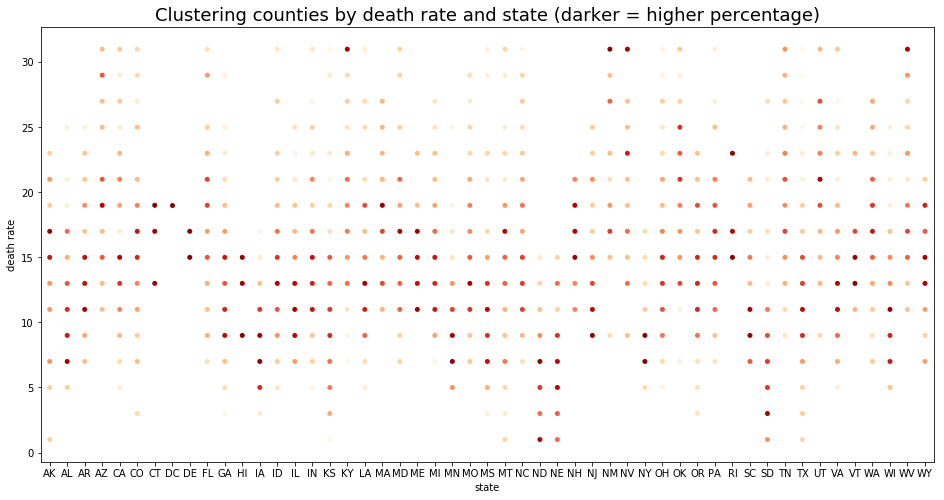

In [913]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')
ax.figure.savefig('images/county_rates.png')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

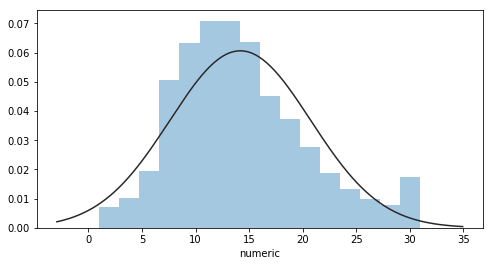

In [914]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = [8.0, 4.0]
target_hist = sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)
target_hist.figure.savefig('images/target_hist.png')

The target distribution is a little skewed but follows a roughly normal curve except for the spike at the highest value. Experimentation found that classification works better with these target outliers included, but the outliers in the predictors need to be dealt with.

In [915]:
target_outliers = list(target_outliers.index)

data_raw = data.copy()
data = data.drop(['state', 'name', 'pop_2014'], axis=1)

In [916]:
bivariate = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.596235  0.185915     0.017175      0.444894   
degree+         0.596235  1.000000  0.437384     0.040137      0.344505   
pop_inc         0.185915  0.437384  1.000000     0.003214      0.265479   
foreign_inc     0.017175  0.040137  0.003214     1.000000      0.006487   
unemployment    0.444894  0.344505  0.265479     0.006487      1.000000   
unemp_change    0.099960  0.104568  0.019885     0.001546      0.183943   
poverty         0.676247  0.454771  0.279422     0.016851      0.615135   
median_hh_inc   0.555187  0.682043  0.471092     0.020453      0.472713   
pov_change      0.026931  0.041624  0.043384     0.000316      0.183201   
median_age      0.207144  0.180067  0.366550     0.037000      0.045748   
hh_afr_am       0.337359  0.078255  0.089242     0.001260      0.393471   
hh_hisp         0.416976  0.014507  0.157683     0.001310      0.007594   
hh_female       0.535661 

**poverty** correlates strongly with several other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [917]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

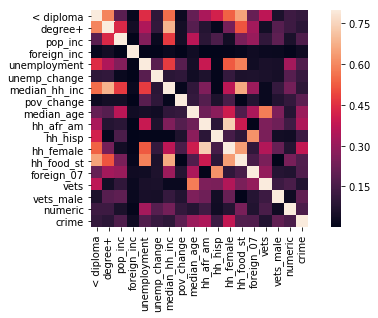

In [918]:
corrmat = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
heatmap = sns.heatmap(corrmat, vmax=.8, square=True)
heatmap.figure.savefig('images/heatmap.png')

There are other correlations, but variance inflation factor (VIF) analysis will be used to determine which should be removed. But first look at outliers in the independent variables.

In [919]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [920]:
data.columns

Index(['< diploma', 'degree+', 'urban_inf', 'pop_inc', 'foreign_inc',
       'unemployment', 'unemp_change', 'median_hh_inc', 'pov_change',
       'median_age', 'hh_afr_am', 'hh_hisp', 'hh_female', 'hh_food_st',
       'foreign_07', 'vets', 'vets_male', 'death_rate', 'numeric', 'crime'],
      dtype='object')

In [921]:
outliers = get_outliers(data.drop(['urban_inf', 'death_rate'], axis=1))
len(data[outliers.any(axis=1)])

1547

In [922]:
extreme_outliers = get_outliers(data.drop(['urban_inf', 'death_rate'], axis=1), 2.5)
len(data[extreme_outliers.any(axis=1)])

927

In [923]:
xx_outliers = list((data[extreme_outliers.sum(axis=1) > 1]).index)
len(xx_outliers)

273

Almost half the dataset contains outliers, and more than a quarter contains extreme outliers that are more than 2.5 times the IQR below the first quartile or above the third. As an alternative to dropping a large number of samples, apply robust scaling to the predictors. Scikit-learn has two solutions, robust scaling and quantile transformation. Try them both. If necessary drop the most extreme (xx) outliers, those samples having more than one extreme outlier.

In [924]:
from sklearn.model_selection import train_test_split

data_train, data_test, targets_train, targets_test = train_test_split(data.drop('death_rate', axis=1),
                                                                     data['death_rate'], test_size=.2,
                                                                     stratify=data['death_rate'], random_state=13)

It is necessary to separate the training and test data before scaling/transforming to prevent data leakage from the test data when fitting the scaling and transformation algorithms. 

In [925]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer
robust = RobustScaler()
quantile = QuantileTransformer()

r_train = pd.DataFrame(robust.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
r_train['urban_inf'] = data_train['urban_inf']

q_train = pd.DataFrame(quantile.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
q_train['urban_inf'] = data_train['urban_inf']

*Note: Both robust scaling and quantile transformation leave binary features unchanged, so __urban_inf__ will be one-hot encoded later.*

Use VIF analysis to programmatically eliminate the variables with the highest VIF scores.

In [926]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
remove = ['urban_inf', 'numeric']
features = r_train.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,4.549152,< diploma
1,3.380767,degree+
2,1.675102,pop_inc
3,1.008448,foreign_inc
4,1.924162,unemployment
5,1.080467,unemp_change
6,3.008699,median_hh_inc
7,1.142916,pov_change
8,2.306545,median_age
9,2.715394,hh_afr_am


In [927]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = r_train.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
    
r_features = list(features.columns) + ['urban_inf']
vif

,VIF,features
0,1.452512,degree+
1,1.410385,pop_inc
2,1.006773,foreign_inc
3,1.458214,unemployment
4,1.064378,unemp_change
5,1.091204,pov_change
6,1.468414,hh_afr_am
7,1.122044,hh_hisp
8,1.163958,vets
9,1.227601,vets_male


In [928]:
vif2 = pd.DataFrame()
remove = ['urban_inf', 'numeric']
features2 = q_train.drop(remove, axis=1)
vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
vif2["features"] = features2.columns
vif2

,VIF,features
0,13.839509,< diploma
1,12.055705,degree+
2,7.332232,pop_inc
3,5.485744,foreign_inc
4,8.442237,unemployment
5,4.526456,unemp_change
6,9.848987,median_hh_inc
7,4.355851,pov_change
8,9.631193,median_age
9,9.378383,hh_afr_am


In [929]:
max_VIF = max(vif2['VIF'])
while len(vif2) > 11:
    remove = remove + list(vif2[vif2['VIF'] == max_VIF]['features'])
    features2 = q_train.drop(remove, axis=1)
    vif2 = pd.DataFrame()
    vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
    vif2["features"] = features2.columns
    max_VIF = max(vif2['VIF'])

q_features = list(features2.columns) + ['urban_inf']   
vif2

,VIF,features
0,6.095568,degree+
1,5.917317,pop_inc
2,5.129618,foreign_inc
3,5.527086,unemployment
4,4.304151,unemp_change
5,3.523071,pov_change
6,6.104386,hh_afr_am
7,5.551572,hh_hisp
8,3.842143,vets
9,3.514568,vets_male


Although the VIF scores were higher with the quantile-transformed data, the order was the same, so proceed with the 11 features from the scaled data that scored below 2.

Try a range of classifiers. 

In [930]:
Xr1_train = r_train.loc[:, r_features]
Xr1_train = pd.get_dummies(Xr1_train, prefix='urb_inf_', columns=['urban_inf'])
Yr1_train = targets_train

Xq1_train = q_train.loc[:, r_features]
Xq1_train = pd.get_dummies(Xq1_train, prefix='urb_inf_', columns=['urban_inf'])
Yq1_train = targets_train

In [931]:
from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [932]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [935]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [936]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['lrc', 'gbc', 'sgd', 'rfc', 'svc', 'knn']
full_names = {'lrc':'Logistic regression', 'gbc':'Gradient boosting', 'sgd':'Stochastic gradient descent',
              'rfc':'Random forest', 'svc':'Support vector', 'knn':'K-Nearest neighbors'}

index = pd.MultiIndex.from_product([['Y16', 'Y8', 'Y4', 'Y2'], ['r', 'q'], [1, 2]])
results = pd.DataFrame(index=index, columns=names)

def run_trials(X, Y, targets, scale, feature_set):
    for name, clf in zip(names, classifiers):
        scores = cross_val_score(clf, X, Y, cv=5, scoring=matthews)
        results.loc[targets, scale, feature_set][name] = np.mean(scores)
        %time print('{} scores: {}'.format(full_names[name], scores))

In [937]:
run_trials(Xr1_train, Yr1_train, 'Y16', 'r', 1)

Logistic regression scores: [ 0.05086417  0.07282134  0.06603775  0.04443182  0.05898859]
CPU times: user 1.75 ms, sys: 106 µs, total: 1.86 ms
Wall time: 464 µs
Gradient boosting scores: [ 0.04641526  0.07536195  0.06416592  0.06177084  0.09184377]
CPU times: user 440 µs, sys: 54 µs, total: 494 µs
Wall time: 477 µs
Stochastic gradient descent scores: [ 0.0344151   0.02383705  0.04745438  0.05397181  0.02920583]
CPU times: user 1.56 ms, sys: 73 µs, total: 1.63 ms
Wall time: 407 µs
Random forest scores: [ 0.03741979  0.01701082  0.06501173  0.02598711  0.07604956]
CPU times: user 375 µs, sys: 48 µs, total: 423 µs
Wall time: 407 µs
Support vector scores: [ 0.07783805  0.09284539  0.0659536   0.07159398  0.09485769]
CPU times: user 404 µs, sys: 50 µs, total: 454 µs
Wall time: 440 µs
K-Nearest neighbors scores: [ 0.07062363  0.01861974  0.07746329  0.03420713  0.06930431]
CPU times: user 380 µs, sys: 32 µs, total: 412 µs
Wall time: 417 µs


All of the stock classifiers performed poorly, with support vector doing the best, followed by gradient boosting and logistic regression.

In [938]:
run_trials(Xq1_train, Yq1_train, 'Y16', 'q', 1)

Logistic regression scores: [ 0.05249489  0.06837129  0.04810064  0.05307293  0.06903587]
CPU times: user 2.63 ms, sys: 220 µs, total: 2.85 ms
Wall time: 721 µs
Gradient boosting scores: [ 0.06354822  0.06196945  0.06606989  0.06196256  0.09073018]
CPU times: user 369 µs, sys: 48 µs, total: 417 µs
Wall time: 405 µs
Stochastic gradient descent scores: [ 0.0382684   0.03000142  0.03315811  0.04686783  0.0570851 ]
CPU times: user 2 ms, sys: 169 µs, total: 2.17 ms
Wall time: 537 µs
Random forest scores: [ 0.03685459  0.05119224  0.0439854   0.01998485  0.07507335]
CPU times: user 397 µs, sys: 48 µs, total: 445 µs
Wall time: 432 µs
Support vector scores: [ 0.02685441  0.05997005  0.053471    0.04396285  0.05533475]
CPU times: user 428 µs, sys: 54 µs, total: 482 µs
Wall time: 469 µs
K-Nearest neighbors scores: [ 0.01657498  0.03476783  0.02542581  0.03843304  0.0462092 ]
CPU times: user 360 µs, sys: 43 µs, total: 403 µs
Wall time: 395 µs


The quantile-transformed data performed even worse. Try an alternative selection process starting with correlations with the target variable.

In [939]:
bivariate = r_train.drop('urban_inf', axis=1).corr().abs()
bivariate.loc['numeric'].drop('numeric')

< diploma        0.137277
degree+          0.135954
pop_inc          0.066918
foreign_inc      0.004850
unemployment     0.315348
unemp_change     0.183969
median_hh_inc    0.241291
pov_change       0.097023
median_age       0.083324
hh_afr_am        0.141008
hh_hisp          0.044675
hh_female        0.071277
hh_food_st       0.247499
foreign_07       0.083056
vets             0.143301
vets_male        0.037117
crime            0.143831
Name: numeric, dtype: float64

In [940]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].drop('numeric').index)

In [941]:
vif = pd.DataFrame()
features = r_train.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,4.091634,< diploma
1,3.349758,degree+
2,1.673822,pop_inc
3,1.887261,unemployment
4,1.077989,unemp_change
5,2.997277,median_hh_inc
6,1.126923,pov_change
7,2.109809,median_age
8,2.551090,hh_afr_am
9,3.868226,hh_female


In [942]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = r_train.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,1.546230,degree+
1,1.549868,pop_inc
2,1.465020,unemployment
3,1.070656,unemp_change
4,1.097285,pov_change
5,1.943621,median_age
6,1.388109,hh_afr_am
7,1.344904,foreign_07
8,1.646127,vets
9,1.318872,crime


In [943]:
features2 = list(vif['features']) + ['urban_inf']
Xr2_train = r_train.loc[:, features2]
Xr2_train = pd.get_dummies(Xr2_train, prefix='urb_inf_', columns=['urban_inf'])
Yr2_train = targets_train

Xq2_train = q_train.loc[:, (features2)]
Xq2_train = pd.get_dummies(Xq2_train, prefix='urb_inf_', columns=['urban_inf'])
Yq2_train = targets_train

In [944]:
run_trials(Xr2_train, Yr2_train, 'Y16', 'r', 2)

Logistic regression scores: [ 0.06412226  0.07609716  0.0511766   0.05193429  0.07408108]
CPU times: user 1.75 ms, sys: 83 µs, total: 1.84 ms
Wall time: 459 µs
Gradient boosting scores: [ 0.06294905  0.05162787  0.08661119  0.05421571  0.09498584]
CPU times: user 490 µs, sys: 65 µs, total: 555 µs
Wall time: 537 µs
Stochastic gradient descent scores: [ 0.03385248  0.03746709  0.06650019  0.04284771  0.06014903]
CPU times: user 5.65 ms, sys: 917 µs, total: 6.57 ms
Wall time: 1.81 ms
Random forest scores: [ 0.05550658  0.07157721  0.06044891  0.05236204  0.10527893]
CPU times: user 1.05 ms, sys: 128 µs, total: 1.17 ms
Wall time: 1.16 ms
Support vector scores: [ 0.07190563  0.07200346  0.09713951  0.09069434  0.10320002]
CPU times: user 384 µs, sys: 45 µs, total: 429 µs
Wall time: 422 µs
K-Nearest neighbors scores: [ 0.04406258  0.06012846  0.07290166  0.03992521  0.05960594]
CPU times: user 537 µs, sys: 113 µs, total: 650 µs
Wall time: 602 µs


In [945]:
run_trials(Xq2_train, Yq2_train, 'Y16', 'q', 2)

Logistic regression scores: [ 0.05536076  0.0661584   0.04062156  0.05498016  0.08575282]
CPU times: user 1.61 ms, sys: 78 µs, total: 1.69 ms
Wall time: 421 µs
Gradient boosting scores: [ 0.02999205  0.0409069   0.09083293  0.05190793  0.08727649]
CPU times: user 409 µs, sys: 52 µs, total: 461 µs
Wall time: 451 µs
Stochastic gradient descent scores: [ 0.01562488  0.03972564  0.05758096  0.05178885  0.03603954]
CPU times: user 1.98 ms, sys: 137 µs, total: 2.12 ms
Wall time: 524 µs
Random forest scores: [ 0.05373383  0.08453299  0.03799896  0.05498294  0.05301281]
CPU times: user 423 µs, sys: 77 µs, total: 500 µs
Wall time: 466 µs
Support vector scores: [ 0.03790855  0.06135298  0.04949953  0.04833966  0.06779856]
CPU times: user 414 µs, sys: 53 µs, total: 467 µs
Wall time: 457 µs
K-Nearest neighbors scores: [ 0.05933857  0.04082642  0.05666089  0.01630364  0.029316  ]
CPU times: user 390 µs, sys: 49 µs, total: 439 µs
Wall time: 433 µs


The scores are very close for both training sets, but also very poor. Try combining targets to make fewer classes.

In [946]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [947]:
Y_16_train = targets_train.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_16_train = Y_16_train.apply(lambda x: '30-31.9' if x == '30+' else x)

Y_8_train = combine_targets(Y_16_train)


In [948]:
run_trials(Xr1_train, Y_8_train, 'Y8', 'r', 1)

Logistic regression scores: [ 0.1321164   0.12608619  0.11768745  0.16575065  0.1230672 ]
CPU times: user 1.58 ms, sys: 82 µs, total: 1.66 ms
Wall time: 416 µs
Gradient boosting scores: [ 0.15625616  0.11245976  0.09628238  0.12214904  0.14966475]
CPU times: user 396 µs, sys: 49 µs, total: 445 µs
Wall time: 434 µs
Stochastic gradient descent scores: [ 0.07146414  0.06225771  0.03675962  0.06354764  0.0873632 ]
CPU times: user 1.63 ms, sys: 71 µs, total: 1.7 ms
Wall time: 425 µs
Random forest scores: [ 0.12293009  0.11344306  0.11428825  0.12119113  0.12829457]
CPU times: user 368 µs, sys: 54 µs, total: 422 µs
Wall time: 404 µs
Support vector scores: [ 0.16176329  0.1552665   0.12118051  0.14181695  0.18066868]
CPU times: user 381 µs, sys: 51 µs, total: 432 µs
Wall time: 419 µs
K-Nearest neighbors scores: [ 0.15527279  0.11922847  0.1264419   0.05341478  0.10179591]
CPU times: user 358 µs, sys: 40 µs, total: 398 µs
Wall time: 390 µs


In [949]:
run_trials(Xr2_train, Y_8_train, 'Y8', 'r', 2)

Logistic regression scores: [ 0.12944753  0.09861998  0.11943153  0.15875462  0.12862111]
CPU times: user 2.13 ms, sys: 203 µs, total: 2.33 ms
Wall time: 589 µs
Gradient boosting scores: [ 0.15661915  0.11279916  0.13877335  0.14226679  0.17363891]
CPU times: user 407 µs, sys: 50 µs, total: 457 µs
Wall time: 446 µs
Stochastic gradient descent scores: [ 0.08349209  0.07375127  0.09280278  0.0832209   0.13114542]
CPU times: user 2.25 ms, sys: 115 µs, total: 2.36 ms
Wall time: 595 µs
Random forest scores: [ 0.12133344  0.1323677   0.07397829  0.11168883  0.14000666]
CPU times: user 415 µs, sys: 48 µs, total: 463 µs
Wall time: 450 µs
Support vector scores: [ 0.17969014  0.14638884  0.15362061  0.17601458  0.14875717]
CPU times: user 474 µs, sys: 64 µs, total: 538 µs
Wall time: 520 µs
K-Nearest neighbors scores: [ 0.13861981  0.1179019   0.10333352  0.09355657  0.12178725]
CPU times: user 409 µs, sys: 62 µs, total: 471 µs
Wall time: 459 µs


In [950]:
run_trials(Xq1_train, Y_8_train, 'Y8', 'q', 1)

Logistic regression scores: [ 0.10162229  0.10126853  0.11825375  0.15335409  0.1460493 ]
CPU times: user 1.67 ms, sys: 84 µs, total: 1.75 ms
Wall time: 435 µs
Gradient boosting scores: [ 0.13463337  0.14436889  0.12276287  0.15094769  0.14406414]
CPU times: user 386 µs, sys: 44 µs, total: 430 µs
Wall time: 418 µs
Stochastic gradient descent scores: [ 0.10419837  0.06386417  0.08789412  0.06599048  0.10857556]
CPU times: user 1.55 ms, sys: 79 µs, total: 1.63 ms
Wall time: 408 µs
Random forest scores: [ 0.13213705  0.07174946  0.1080819   0.08751764  0.13621233]
CPU times: user 383 µs, sys: 50 µs, total: 433 µs
Wall time: 418 µs
Support vector scores: [ 0.11399134  0.11040416  0.10278132  0.14003048  0.10866748]
CPU times: user 389 µs, sys: 52 µs, total: 441 µs
Wall time: 429 µs
K-Nearest neighbors scores: [ 0.09498106  0.09107381  0.09035221  0.15025924  0.06981338]
CPU times: user 478 µs, sys: 66 µs, total: 544 µs
Wall time: 523 µs


In [951]:
run_trials(Xq2_train, Y_8_train, 'Y8', 'q', 2)

Logistic regression scores: [ 0.12785724  0.11110969  0.123671    0.14998998  0.15340912]
CPU times: user 2.01 ms, sys: 132 µs, total: 2.14 ms
Wall time: 526 µs
Gradient boosting scores: [ 0.12680603  0.13410442  0.10383225  0.12777934  0.16901651]
CPU times: user 370 µs, sys: 47 µs, total: 417 µs
Wall time: 402 µs
Stochastic gradient descent scores: [ 0.08006019  0.09152391  0.07221708  0.08152844  0.09595232]
CPU times: user 2.24 ms, sys: 125 µs, total: 2.37 ms
Wall time: 583 µs
Random forest scores: [ 0.15639983  0.1120778   0.06329557  0.14433139  0.12254405]
CPU times: user 403 µs, sys: 48 µs, total: 451 µs
Wall time: 444 µs
Support vector scores: [ 0.10983792  0.10707372  0.08299396  0.14146136  0.12116338]
CPU times: user 372 µs, sys: 50 µs, total: 422 µs
Wall time: 404 µs
K-Nearest neighbors scores: [ 0.09086141  0.12156315  0.12144978  0.12652622  0.10239106]
CPU times: user 383 µs, sys: 36 µs, total: 419 µs
Wall time: 413 µs


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [952]:
Y_4_train = combine_targets(Y_8_train)

In [953]:
run_trials(Xr1_train, Y_4_train, 'Y4', 'r', 1)

Logistic regression scores: [ 0.24111678  0.29677785  0.2335296   0.24637144  0.25710789]
CPU times: user 1.87 ms, sys: 135 µs, total: 2.01 ms
Wall time: 500 µs
Gradient boosting scores: [ 0.28371812  0.22359973  0.24676684  0.30355216  0.24540668]
CPU times: user 572 µs, sys: 126 µs, total: 698 µs
Wall time: 633 µs
Stochastic gradient descent scores: [ 0.08826504  0.18323008  0.13911     0.16819022  0.09971837]
CPU times: user 1.93 ms, sys: 301 µs, total: 2.23 ms
Wall time: 764 µs
Random forest scores: [ 0.22923467  0.2052008   0.21288875  0.15193052  0.20464668]
CPU times: user 399 µs, sys: 49 µs, total: 448 µs
Wall time: 437 µs
Support vector scores: [ 0.25490224  0.29562512  0.27366052  0.28031115  0.28125678]
CPU times: user 563 µs, sys: 72 µs, total: 635 µs
Wall time: 618 µs
K-Nearest neighbors scores: [ 0.22669223  0.26371651  0.17223466  0.1753743   0.20189916]
CPU times: user 386 µs, sys: 31 µs, total: 417 µs
Wall time: 424 µs


In [954]:
run_trials(Xr2_train, Y_4_train, 'Y4', 'r', 2)

Logistic regression scores: [ 0.20733347  0.26372434  0.21958306  0.24569324  0.27005468]
CPU times: user 2.81 ms, sys: 222 µs, total: 3.03 ms
Wall time: 756 µs
Gradient boosting scores: [ 0.31154593  0.25577977  0.24800647  0.29730169  0.29253908]
CPU times: user 397 µs, sys: 48 µs, total: 445 µs
Wall time: 433 µs
Stochastic gradient descent scores: [ 0.09927232  0.1254128   0.19847473  0.18435574  0.13184086]
CPU times: user 1.63 ms, sys: 81 µs, total: 1.71 ms
Wall time: 429 µs
Random forest scores: [ 0.19934942  0.20364685  0.20628974  0.21866901  0.22646789]
CPU times: user 374 µs, sys: 49 µs, total: 423 µs
Wall time: 408 µs
Support vector scores: [ 0.27116062  0.28695198  0.31797694  0.33580963  0.25736527]
CPU times: user 413 µs, sys: 46 µs, total: 459 µs
Wall time: 446 µs
K-Nearest neighbors scores: [ 0.2239976   0.25488042  0.21285002  0.23744324  0.23771442]
CPU times: user 364 µs, sys: 26 µs, total: 390 µs
Wall time: 395 µs


In [955]:
run_trials(Xq1_train, Y_4_train, 'Y4', 'q', 1)

Logistic regression scores: [ 0.22116479  0.23299329  0.21087918  0.23937598  0.2780047 ]
CPU times: user 1.66 ms, sys: 121 µs, total: 1.78 ms
Wall time: 445 µs
Gradient boosting scores: [ 0.26652348  0.21790389  0.23468266  0.28361578  0.25646593]
CPU times: user 367 µs, sys: 48 µs, total: 415 µs
Wall time: 400 µs
Stochastic gradient descent scores: [ 0.13782795  0.17477684  0.17955375  0.16834757  0.23984268]
CPU times: user 2.21 ms, sys: 203 µs, total: 2.42 ms
Wall time: 636 µs
Random forest scores: [ 0.26874577  0.18110542  0.18501762  0.19344226  0.24045222]
CPU times: user 368 µs, sys: 51 µs, total: 419 µs
Wall time: 404 µs
Support vector scores: [ 0.19170348  0.25420771  0.21172118  0.24394988  0.24288247]
CPU times: user 373 µs, sys: 47 µs, total: 420 µs
Wall time: 409 µs
K-Nearest neighbors scores: [ 0.12390461  0.21607539  0.16480607  0.19959109  0.15646635]
CPU times: user 376 µs, sys: 42 µs, total: 418 µs
Wall time: 411 µs


In [956]:
run_trials(Xq2_train, Y_4_train, 'Y4', 'q', 2)

Logistic regression scores: [ 0.22452283  0.23788297  0.21214018  0.27655495  0.2738415 ]
CPU times: user 1.94 ms, sys: 198 µs, total: 2.14 ms
Wall time: 541 µs
Gradient boosting scores: [ 0.30758168  0.26713498  0.28044592  0.29316499  0.28584792]
CPU times: user 437 µs, sys: 96 µs, total: 533 µs
Wall time: 513 µs
Stochastic gradient descent scores: [ 0.09754587  0.21773917  0.19326022  0.21169039  0.11202905]
CPU times: user 1.51 ms, sys: 109 µs, total: 1.62 ms
Wall time: 419 µs
Random forest scores: [ 0.25018653  0.19682672  0.21578956  0.19285591  0.23624485]
CPU times: user 417 µs, sys: 55 µs, total: 472 µs
Wall time: 459 µs
Support vector scores: [ 0.1876356   0.24472353  0.22042767  0.26994928  0.23997731]
CPU times: user 416 µs, sys: 48 µs, total: 464 µs
Wall time: 449 µs
K-Nearest neighbors scores: [ 0.14464612  0.23508972  0.19954673  0.25354423  0.16324948]
CPU times: user 359 µs, sys: 31 µs, total: 390 µs
Wall time: 395 µs


In [957]:
Y_2_train = combine_targets(Y_4_train)

In [958]:
run_trials(Xr1_train, Y_2_train, 'Y2', 'r', 1)

Logistic regression scores: [ 0.43167188  0.43716142  0.33032901  0.38145576  0.44886286]
CPU times: user 455 µs, sys: 53 µs, total: 508 µs
Wall time: 514 µs
Gradient boosting scores: [ 0.39295262  0.41963703  0.35488716  0.40513891  0.42075466]
CPU times: user 423 µs, sys: 47 µs, total: 470 µs
Wall time: 456 µs
Stochastic gradient descent scores: [ 0.32241528  0.27156272  0.24350259  0.24062507  0.40652804]
CPU times: user 396 µs, sys: 42 µs, total: 438 µs
Wall time: 431 µs
Random forest scores: [ 0.378223    0.32143512  0.28146764  0.28709467  0.3065817 ]
CPU times: user 378 µs, sys: 51 µs, total: 429 µs
Wall time: 416 µs
Support vector scores: [ 0.3775485   0.48733972  0.38074459  0.39140343  0.47187592]
CPU times: user 384 µs, sys: 62 µs, total: 446 µs
Wall time: 418 µs
K-Nearest neighbors scores: [ 0.37936868  0.38583587  0.28353895  0.30880422  0.37139128]
CPU times: user 497 µs, sys: 81 µs, total: 578 µs
Wall time: 548 µs


In [959]:
run_trials(Xr2_train, Y_2_train, 'Y2', 'r', 2)

Logistic regression scores: [ 0.42618452  0.42513564  0.35899455  0.38593217  0.4251092 ]
CPU times: user 449 µs, sys: 62 µs, total: 511 µs
Wall time: 489 µs
Gradient boosting scores: [ 0.38513774  0.43915503  0.37605331  0.37161997  0.46805529]
CPU times: user 406 µs, sys: 49 µs, total: 455 µs
Wall time: 440 µs
Stochastic gradient descent scores: [ 0.17020878  0.34782961  0.18299162  0.31086803  0.18311287]
CPU times: user 621 µs, sys: 79 µs, total: 700 µs
Wall time: 686 µs
Random forest scores: [ 0.35090501  0.32949443  0.27699072  0.30588534  0.35931672]
CPU times: user 390 µs, sys: 268 µs, total: 658 µs
Wall time: 647 µs
Support vector scores: [ 0.43023769  0.48165018  0.40594639  0.44691304  0.43776314]
CPU times: user 407 µs, sys: 52 µs, total: 459 µs
Wall time: 444 µs
K-Nearest neighbors scores: [ 0.31719041  0.42944875  0.32856167  0.4399548   0.33596374]
CPU times: user 412 µs, sys: 46 µs, total: 458 µs
Wall time: 464 µs


In [960]:
run_trials(Xq1_train, Y_2_train, 'Y2', 'q', 1)

Logistic regression scores: [ 0.2972942   0.37115397  0.25967329  0.3340202   0.38267578]
CPU times: user 366 µs, sys: 45 µs, total: 411 µs
Wall time: 399 µs
Gradient boosting scores: [ 0.35939606  0.42842498  0.36121478  0.4114983   0.43059699]
CPU times: user 541 µs, sys: 56 µs, total: 597 µs
Wall time: 604 µs
Stochastic gradient descent scores: [ 0.29544566  0.23611596  0.25351706  0.24278026  0.30709921]
CPU times: user 385 µs, sys: 35 µs, total: 420 µs
Wall time: 425 µs
Random forest scores: [ 0.26891534  0.33446239  0.26380669  0.39279255  0.31475217]
CPU times: user 378 µs, sys: 47 µs, total: 425 µs
Wall time: 417 µs
Support vector scores: [ 0.29994768  0.39759252  0.30692306  0.32998724  0.39304805]
CPU times: user 373 µs, sys: 49 µs, total: 422 µs
Wall time: 411 µs
K-Nearest neighbors scores: [ 0.28055197  0.33031239  0.27146334  0.31050098  0.27863159]
CPU times: user 424 µs, sys: 47 µs, total: 471 µs
Wall time: 459 µs


In [961]:
run_trials(Xq2_train, Y_2_train, 'Y2', 'q', 2)

Logistic regression scores: [ 0.29759495  0.37115397  0.27212242  0.34503506  0.33551655]
CPU times: user 679 µs, sys: 156 µs, total: 835 µs
Wall time: 740 µs
Gradient boosting scores: [ 0.36814063  0.43652168  0.34853982  0.39961019  0.49349375]
CPU times: user 370 µs, sys: 45 µs, total: 415 µs
Wall time: 413 µs
Stochastic gradient descent scores: [ 0.29018522  0.26024534  0.21956142  0.18770827  0.24568734]
CPU times: user 364 µs, sys: 31 µs, total: 395 µs
Wall time: 401 µs
Random forest scores: [ 0.3884235   0.33545666  0.33829455  0.34709783  0.37455584]
CPU times: user 428 µs, sys: 56 µs, total: 484 µs
Wall time: 462 µs
Support vector scores: [ 0.30022185  0.37377346  0.2691068   0.367602    0.3692935 ]
CPU times: user 486 µs, sys: 53 µs, total: 539 µs
Wall time: 543 µs
K-Nearest neighbors scores: [ 0.3019092   0.35563773  0.28177393  0.36219638  0.21007284]
CPU times: user 457 µs, sys: 43 µs, total: 500 µs
Wall time: 505 µs


In [962]:
results

lrc        gbc        sgd        rfc        svc        knn
Y16 r 1  0.0586287  0.0679115  0.0377768  0.0442958  0.0806177  0.0540436
      2  0.0634823  0.0700779  0.0481633  0.0690347  0.0869886  0.0553248
    q 1  0.0582151  0.0688561  0.0410762  0.0454181  0.0479186  0.0322822
      2  0.0605747  0.0601833   0.040152  0.0568523  0.0529799  0.0404891
Y8  r 1   0.132942   0.127362  0.0642785   0.120029   0.152139   0.111231
      2   0.126975   0.144819  0.0928825   0.115875   0.160894    0.11504
    q 1    0.12411   0.139355  0.0861045    0.10714   0.115175  0.0992959
      2   0.133207   0.132308  0.0842564    0.11973   0.112506   0.112558
Y4  r 1   0.254981   0.260609   0.135703    0.20078   0.277151   0.207983
      2   0.241278   0.281035   0.147871   0.210885   0.293853   0.233377
    q 1   0.236484   0.251838    0.18007   0.213753   0.228893   0.172169
      2   0.244988   0.286835   0.166453   0.218381   0.232543   0.199215
Y2  r 1   0.405896   0.398674   0.296927    0.31496   0.421782   0.345788
      2   0.404271   0.408004   0.239002   0.324518   0.440502   0.370224
    q 1   0.328963   0.398226   0.266992   0.314946     0.3455   0.294292
      2   0.324285   0.409261   0.240678   0.356766      0.336   0.302318

The data cannot perform better than reasonably well on binary classification, where robust scaling clearly outperforms quantile transformation on the three highest-scoring algorithms — support vector, logistic regression amd gradient boosting. The second feature set performs better, but would performance improve by dropping the most extreme outliers?

In [963]:
train_xx = list(set(xx_outliers) & set(list(data_train.index)))
test_xx = list(set(xx_outliers) & set(list(data_test.index)))

In [964]:
Xr1_noxx_train = Xr1_train.drop(train_xx)
Xr2_noxx_train = Xr2_train.drop(train_xx)
Y_2_noxx_train = Y_2_train.drop(train_xx)

In [965]:
index2 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
results2 = pd.DataFrame(index=index2, columns=names)

results2.loc['full', 1] = results.loc['Y2', 'r', 1]
results2.loc['full', 2] = results.loc['Y2', 'r', 2]


def run_trials2(X, Y, selected, feature_set):
    for name, clf in zip(names, classifiers):
        score = np.mean(cross_val_score(clf, X, Y, cv=5, scoring=matthews))
        results2.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [966]:
run_trials2(Xr1_noxx_train, Y_2_noxx_train, 'no_xx', 1)

Logistic regression average score: 0.4056613832042782
CPU times: user 70 µs, sys: 47 µs, total: 117 µs
Wall time: 105 µs
Gradient boosting average score: 0.4042536807096672
CPU times: user 77 µs, sys: 47 µs, total: 124 µs
Wall time: 107 µs
Stochastic gradient descent average score: 0.28466801367642225
CPU times: user 56 µs, sys: 28 µs, total: 84 µs
Wall time: 88 µs
Random forest average score: 0.29164647598965676
CPU times: user 68 µs, sys: 47 µs, total: 115 µs
Wall time: 104 µs
Support vector average score: 0.4382835309464636
CPU times: user 79 µs, sys: 48 µs, total: 127 µs
Wall time: 108 µs
K-Nearest neighbors average score: 0.3602592184275963
CPU times: user 59 µs, sys: 32 µs, total: 91 µs
Wall time: 96.1 µs


In [967]:
run_trials2(Xr2_noxx_train, Y_2_noxx_train, 'no_xx', 2)

Logistic regression average score: 0.41151109255300933
CPU times: user 108 µs, sys: 121 µs, total: 229 µs
Wall time: 197 µs
Gradient boosting average score: 0.3968723565322684
CPU times: user 152 µs, sys: 90 µs, total: 242 µs
Wall time: 214 µs
Stochastic gradient descent average score: 0.31406481700184186
CPU times: user 55 µs, sys: 28 µs, total: 83 µs
Wall time: 87 µs
Random forest average score: 0.35162322026120235
CPU times: user 78 µs, sys: 54 µs, total: 132 µs
Wall time: 119 µs
Support vector average score: 0.43289122441388467
CPU times: user 64 µs, sys: 43 µs, total: 107 µs
Wall time: 102 µs
K-Nearest neighbors average score: 0.35843025979023346
CPU times: user 65 µs, sys: 42 µs, total: 107 µs
Wall time: 101 µs


In [968]:
results2

lrc       gbc       sgd       rfc       svc       knn
full  1  0.405896  0.398674  0.296927   0.31496  0.421782  0.345788
      2  0.404271  0.408004  0.239002  0.324518  0.440502  0.370224
no_xx 1  0.405661  0.404254  0.284668  0.291646  0.438284  0.360259
      2  0.411511  0.396872  0.314065  0.351623  0.432891   0.35843

The choices between the full dataset or the dataset without the most extreme outliers, and between the feaure sets is not clear. See how the top three models perform on the test set.

In [969]:
r_test = pd.DataFrame(robust.fit_transform(data_test.drop(['urban_inf'], axis=1)),
                       index=data_test.index, columns=data_test.drop(['urban_inf'], axis=1).columns)
r_test['urban_inf'] = data_test['urban_inf']

Xr1_test = r_test.loc[:, r_features]
Xr1_test = pd.get_dummies(Xr1_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_test = r_test.loc[:, features2]
Xr2_test = pd.get_dummies(Xr2_test, prefix='urb_inf_', columns=['urban_inf'])

Xr1_noxx_test = r_test.loc[:, r_features].drop(test_xx)
Xr1_noxx_test = pd.get_dummies(Xr1_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_noxx_test = r_test.loc[:, features2].drop(test_xx)
Xr2_noxx_test = pd.get_dummies(Xr2_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Y_16_test = targets_test.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_16_test = Y_16_test.apply(lambda x: '30-31.9' if x == '30+' else x)
Y_8_test = combine_targets(Y_16_test)
Y_4_test = combine_targets(Y_8_test)
Y_2_test = combine_targets(Y_4_test)

Y_2_noxx_test = Y_2_test.drop(test_xx)

In [970]:
index3 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
names3 = ['lrc', 'gbc', 'svc']
classifiers3 = [classifiers[i] for i in [0, 1, 4]]
results3 = pd.DataFrame(index=index3, columns=names3)

def run_trials3(X_train, X_test, Y_train, Y_test, selected, feature_set):
    for name, clf in zip(names3, classifiers3):
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        score = matthews_corrcoef(Y_test, Y_pred)
        results3.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [971]:
run_trials3(Xr1_train, Xr1_test, Y_2_train, Y_2_test, 'full', 1)

Logistic regression average score: 0.3599204025324622
CPU times: user 803 µs, sys: 113 µs, total: 916 µs
Wall time: 220 µs
Gradient boosting average score: 0.39099022521044685
CPU times: user 74 µs, sys: 46 µs, total: 120 µs
Wall time: 106 µs
Support vector average score: 0.36786152851482773
CPU times: user 74 µs, sys: 48 µs, total: 122 µs
Wall time: 108 µs


In [972]:
run_trials3(Xr2_train, Xr2_test, Y_2_train, Y_2_test, 'full', 2)

Logistic regression average score: 0.3722667110752942
CPU times: user 699 µs, sys: 251 µs, total: 950 µs
Wall time: 323 µs
Gradient boosting average score: 0.39434950071387503
CPU times: user 70 µs, sys: 51 µs, total: 121 µs
Wall time: 107 µs
Support vector average score: 0.38445348724604494
CPU times: user 68 µs, sys: 45 µs, total: 113 µs
Wall time: 97 µs


In [973]:
run_trials3(Xr1_noxx_train, Xr1_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 1)

Logistic regression average score: 0.3799486774825333
CPU times: user 913 µs, sys: 176 µs, total: 1.09 ms
Wall time: 273 µs
Gradient boosting average score: 0.39480838688883063
CPU times: user 72 µs, sys: 50 µs, total: 122 µs
Wall time: 109 µs
Support vector average score: 0.3846390616316681
CPU times: user 125 µs, sys: 89 µs, total: 214 µs
Wall time: 185 µs


In [974]:
run_trials3(Xr2_noxx_train, Xr2_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 2)

Logistic regression average score: 0.3853984655080666
CPU times: user 842 µs, sys: 124 µs, total: 966 µs
Wall time: 236 µs
Gradient boosting average score: 0.42078681573621357
CPU times: user 83 µs, sys: 50 µs, total: 133 µs
Wall time: 112 µs
Support vector average score: 0.390006747579955
CPU times: user 105 µs, sys: 92 µs, total: 197 µs
Wall time: 154 µs


In [975]:
results3

lrc       gbc       svc
full  1   0.35992   0.39099  0.367862
      2  0.372267   0.39435  0.384453
no_xx 1  0.379949  0.394808  0.384639
      2  0.385398  0.420787  0.390007

The feature set with the most extreme outliers removed performed better with all the classifiers, as did the second feature set. Both will be optimized, since the support vector scores are not much higher and logistic regression results are more interpretable. The second feature also consistently outperfoms the first with both of these classifiers.

In [976]:
Y_bi_train = data.loc[list(Y_2_noxx_train.index), 'numeric'].apply(lambda x: 0 if x < 15 else 1)
Y_bi_test = data.loc[list(Y_2_noxx_test.index), 'numeric'].apply(lambda x: 0 if x < 15 else 1)

In [977]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [978]:
def optimize(clf, params, X_train, X_test, Y_train, Y_test):
    model = GridSearchCV(clf, param_grid=params, scoring=matthews)
    model.fit(X_train, Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    preds = model.predict(X_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(X_test))
    plt.scatter(residuals.index, residuals)
    return model

In [987]:
gbc_params = { 'loss': ['deviance', 'exponential'], 'learning_rate': [.01, .05, .1, .15],
                'n_estimators': [50, 100, 150], 'max_depth': [3, 4],
                'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2]}

svc_params = {'C': [0.5, 1, 4, 7], 'kernel': ['linear', 'poly', 'rbf'],
             'gamma': [0.1, 0.12, 0.14], 'tol': [1e-7, 5e-7, 1e-6, 5e-6]}


Optimal parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
Matthews score: 0.44679152383970955
ROC-AUC score: 0.7224836284259034
[[237  73]
 [ 85 181]]


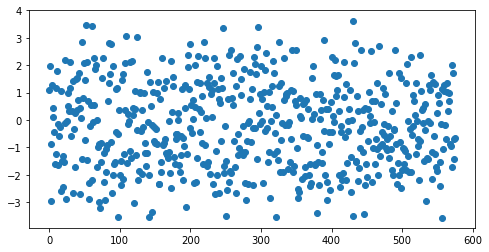

In [988]:
gbc_1 = optimize(gbc, gbc_params, Xr2_noxx_train, Xr2_noxx_test, Y_bi_train, Y_bi_test)

Optimal parameters: {'C': 1, 'gamma': 0.14, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.45729204350294067
ROC-AUC score: 0.7291777831675964
[[226  84]
 [ 72 194]]


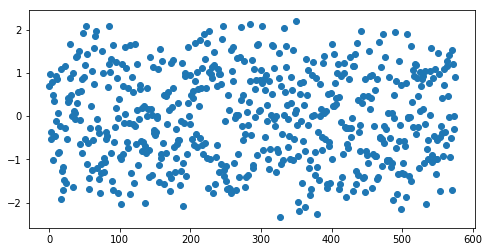

In [989]:
svc_1 = optimize(svc, svc_params, Xr2_noxx_train, Xr2_noxx_test, Y_bi_train, Y_bi_test)